In [45]:
''' compute & plot taux, tauy, taux_correct, tauy_correct, raw & NI-bandpassed velocity, AND wind power input & integral of wind power input
    Saildrone wind data: 1-min average of 20Hz data.
    Saildrone current data: 5-min average of 1Hz data. 
    FOR drones that intercepted / close to HU LEE 2023: 
    (1) 1041 (~9/12 > 34 kt, N-PR, S of Lee) --> (later ~10/25 > 44 kt, N of Anguilla EEZ, around HU Tammy)
    (2) 1036 (~8/25 > 25 kt, N-PR, N of HU Franklin) --> (~9/13 > 50 kt, N-PR, N --> center --> S of Lee)
    (3) 1064 (~8/26 > 45 kt, N-PR, N & right side of HU Franklin) (~9/12 > 63 kt, N-PR, N & right side of Lee --> broke)
    (4) 1065 (~9/1 > 25 kt, N end of satellite line, NW side of post-tropical Idalia) (~9/13 > 45 kt, E of Domain E, N of Lee --> broke)
    (5) 1069 (~9/8 > 38 kt, Domain A, before it became HU Lee)
    ---
    This version computes hourly wind power from averaged wind and velocity. 
    This version includes total wind power, not just the wind power to near-inertial motion
    --- 
    v2 tries to add coare3.6 flux, which is not successfully computed... can see the plots 
'''
import numpy as np
import netCDF4 as nc
import matplotlib
import matplotlib.pyplot as plt
import datetime
import os
import math
import sys
import re
from numpy.linalg import norm
from scipy.interpolate import interp1d
from metpy.calc import wind_components, density, mixing_ratio_from_relative_humidity, wind_direction
from metpy.units import units
from oceans.ocfis import spdir2uv
# from metpy import calc
path_nhchi = os.path.expanduser('~/Documents/projects/analytical-tools/py_nhchi/')
# adding to the system path
sys.path.insert(0, path_nhchi)
from windstr import ra_windstr_nc
from coare36vn_zrf_et import coare36vn_zrf_et
from coare36vnWarm_et import coare36vnWarm_et
from convert_dir import vector_dir_to_from, convert_dir_to_from
from convert_time import datetime_to_yearday
from mystats import bandpass
from values_to_colors import values_to_rgba
from metpy.units import units
from metpy.calc import wind_components

In [2]:
### Data info
### SD data info
year = '2023'
iSD = 0
platf_num = ['1036','1041','1069']
print('Now looking at SD-'+platf_num[iSD])
path_met_SD = '/Users/chi/Documents/projects/sd-ni-wp/data_manipulate/data_merge_airsea/'
path_cur_SD = '/Users/chi/Documents/projects/sd-adcp-manipulate/check_adcp_redelivery/data_merge_adcp_redelivery/'
### merged nc file info
tlim_plot = [[datetime.datetime(int(year),9,7), datetime.datetime(int(year),9,19)],\
             [datetime.datetime(int(year),9,6), datetime.datetime(int(year),9,18)],\
                [datetime.datetime(int(year),9,3), datetime.datetime(int(year),9,15)]]
nday_plot = [(item[1]-item[0]).days for item in tlim_plot]
print(tlim_plot)
print(nday_plot,'days')
tticks = [tlim_plot[iSD][0]+datetime.timedelta(days=i) for i in range(nday_plot[iSD])]
tticks_label = [tticks[i].strftime('%m/%d') for i in range(len(tticks))]

Now looking at SD-1036
[[datetime.datetime(2023, 9, 7, 0, 0), datetime.datetime(2023, 9, 19, 0, 0)], [datetime.datetime(2023, 9, 6, 0, 0), datetime.datetime(2023, 9, 18, 0, 0)], [datetime.datetime(2023, 9, 3, 0, 0), datetime.datetime(2023, 9, 15, 0, 0)]]
[12, 12, 12] days


In [3]:
''' load SD's airsea data '''
ds_met_SD = nc.Dataset(path_met_SD+'airsea-raw-merge-'+year+'-SD'+platf_num[iSD]+'.nc')
print(ds_met_SD)
time = ds_met_SD.variables['time'][:]
dtime_met_SD = np.array([datetime.datetime(int(year),1,1)+datetime.timedelta(seconds=time[i]) for i in range(len(time))])
lon_met_SD = ds_met_SD.variables['longitude'][:]
lat_met_SD = ds_met_SD.variables['latitude'][:]
uwnd_SD = ds_met_SD.variables['UWND_MEAN'][:]
vwnd_SD = ds_met_SD.variables['VWND_MEAN'][:]
ta_SD = ds_met_SD.variables['TEMP_AIR_MEAN'][:]
rh_SD = ds_met_SD.variables['RH_MEAN'][:]
bp_SD = ds_met_SD.variables['BARO_PRES_MEAN'][:]
sw_dn_SD = ds_met_SD.variables['PAR_AIR_MEAN'][:]/2.4 # W/m^2
# WAVE_DOMINANT_PERIOD_SD = ds_met_SD.variables['WAVE_DOMINANT_PERIOD'][:]
sigH_SD = ds_met_SD.variables['WAVE_SIGNIFICANT_HEIGHT'][:]
ts_SD = ds_met_SD.variables['TEMP_SBE37_MEAN'][:]
ss_SD = ds_met_SD.variables['SAL_SBE37_MEAN'][:]
curspd_SD = ds_met_SD.variables['WATER_CURRENT_SPEED_MEAN'][:]
curdir_SD = ds_met_SD.variables['WATER_CURRENT_DIRECTION_MEAN'][:]
curdir_from_SD = convert_dir_to_from(curdir_SD)
ucur_SD, vcur_SD = wind_components(units.Quantity(curspd_SD, "m/s"), units.Quantity(curdir_from_SD, "degree"))
ucur = np.array(ucur_SD)
vcur = np.array(vcur_SD)    
print('SD met data time:',dtime_met_SD[0:2],'...',dtime_met_SD[-1])
zu = 3.5
zt = 2.3
zq = 2.3

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    title: Merged files for 2023 SD-1036 from /Volumes/disk3/projects/sdig-external/sdig/saildrone/hurricane_monitoring_2023/delayed_post_mission/sd-1036/
    subtitle: Only selected variables for COARE flux calculations are here. Temporal resolution is 1-minute.
    dimensions(sizes): time(125280)
    variables(dimensions): float64 time(time), float64 UWND_MEAN(time), float64 UWND_STDDEV(time), float64 VWND_MEAN(time), float64 VWND_STDDEV(time), float64 GUST_WND_MEAN(time), float64 GUST_WND_STDDEV(time), float64 WIND_MEASUREMENT_HEIGHT_MEAN(time), float64 TEMP_AIR_MEAN(time), float64 RH_MEAN(time), float64 BARO_PRES_MEAN(time), float64 PAR_AIR_MEAN(time), float64 WAVE_DOMINANT_PERIOD(time), float64 WAVE_SIGNIFICANT_HEIGHT(time), float64 TEMP_DEPTH_HALFMETER_MEAN(time), float64 TEMP_SBE37_MEAN(time), float64 TEMP_SBE37_STDDEV(time), float64 SAL_SBE37_MEAN(time), float64 SAL_SBE37_STDDEV(time),

/Users/chi/Documents/projects/analytical-tools/py_nhchi/convert_dir.py:52: RuntimeWarning: invalid value encountered in remainder
  res = (dir + 180)%360


In [4]:
''' check shape of met variables & plot '''
vars_str = ['uwnd_SD','vwnd_SD','ta_SD','rh_SD','bp_SD','sw_dn_SD','sigH_SD','ts_SD','ss_SD','ucur_SD','vcur_SD']
for i, var_str in enumerate( vars_str ):
    print(eval(var_str).shape)

(125280,)
(125280,)
(125280,)
(125280,)
(125280,)
(125280,)
(125280,)
(125280,)
(125280,)
(125280,)
(125280,)


13.79%


<Figure size 432x288 with 0 Axes>

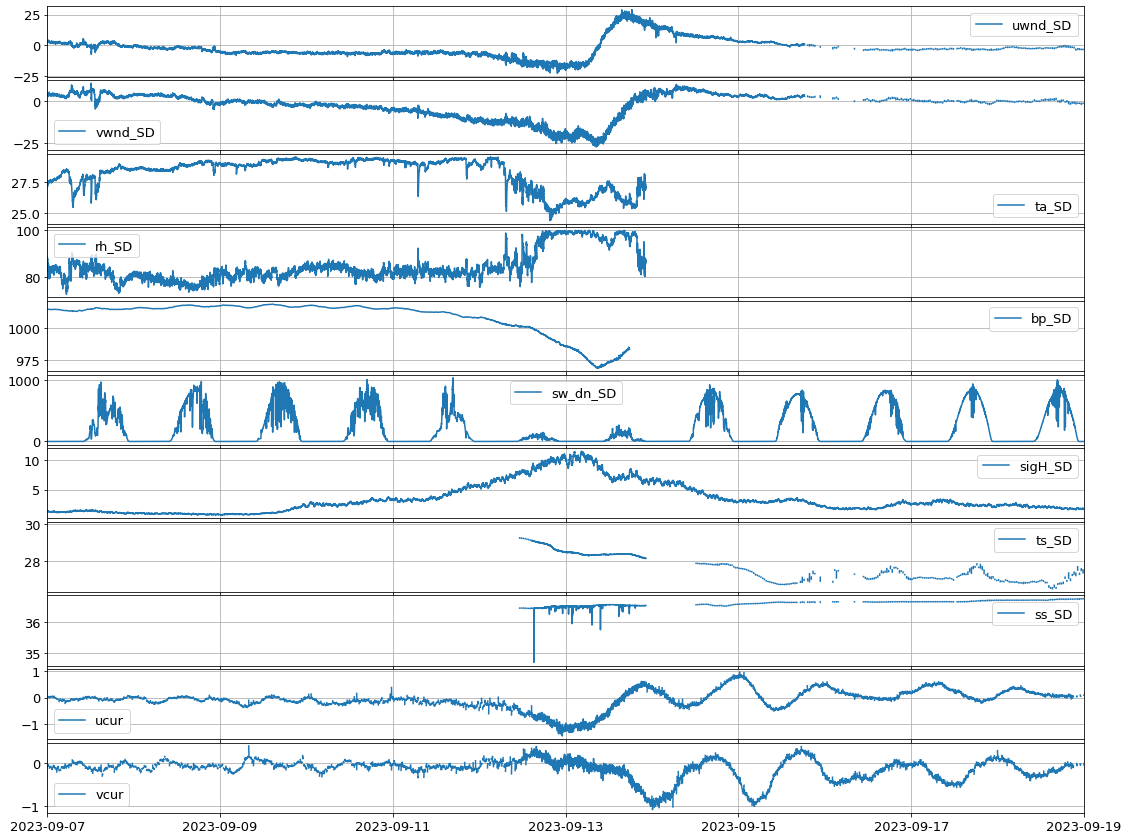

In [10]:
''' plot met variables & plot '''
vars_str = ['uwnd_SD','vwnd_SD','ta_SD','rh_SD','bp_SD','sw_dn_SD','sigH_SD','ts_SD','ss_SD','ucur','vcur']
it_plot = np.where( (dtime_met_SD>= tlim_plot[iSD][0]) & (dtime_met_SD< tlim_plot[iSD][1]) )[0]
print('{:.2f}%'.format(len(it_plot)/len(dtime_met_SD)*100))
nrow = len(vars_str); ncol = 1
plt.clf()
fig = plt.figure(figsize=(18,14))
plt.rcParams.update({'font.size': 13})
for i, var_str in enumerate( vars_str ):
    data = eval( var_str+'[it_plot]' )
    plt.subplot(nrow,ncol,i+1)
    plt.plot(dtime_met_SD[it_plot], data, label=var_str)
    plt.grid()
    plt.legend(loc='best')
    if i < len(vars_str)-1:
        plt.gca().set_xticklabels([])
    ''' limit to time of interest '''
    plt.xlim(tlim_plot[iSD])
plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.3,hspace=0.05)

<Figure size 432x288 with 0 Axes>

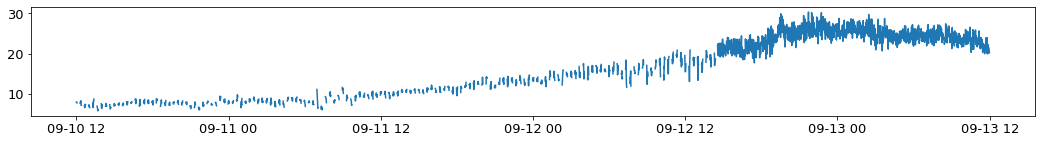

In [67]:
''' compute the wind stress '''
''' COARE3.6'''
it = np.where( (dtime_met_SD>= datetime.datetime(int(year),9,10,12)) & (dtime_met_SD< datetime.datetime(int(year),9,13,12)) )[0]
wdsp_relative_to_water = np.sqrt( np.square(uwnd_SD-ucur_SD) + np.square(vwnd_SD-vcur_SD) )
plt.clf()
fig = plt.figure(figsize=(18,2))
plt.plot(dtime_met_SD[it], wdsp_relative_to_water[it] )
jd_grid = np.nan*np.ones( dtime_met_SD.shape )
for j, dtime in enumerate( dtime_met_SD ):
    _, jd_grid[j] = datetime_to_yearday( dtime )
nan_grid = np.nan*np.ones( dtime_met_SD.shape )
# C_out = coare36vn_zrf_et(u=wdsp_relative_to_water, zu=zu, t=ta_SD_grid, zt=zt, rh=rh_SD_grid, zq=zq, P=bp_SD_grid, ts=ts_SD_grid, sw_dn=sw_dn_SD_grid, lw_dn=nan_grid,\
#                          lat=lat_SD_grid, lon=lon_SD_grid, jd=jd_grid, zi=nan_grid, rain=[0], Ss=ss_SD_grid, cp=None, sigH=None, zrf_u=10.0, zrf_q=10.0, zrf_t=10.0)
test = np.ones((3,))
# C_out = coare36vn_zrf_et(u=np.array([3,5,10]), zu=zu, t=np.array([27,28,27.5]), zt=zt, rh=np.array([85,85,85]), zq=zq, P=np.array([1000,1000,1000]), ts=np.array([29,29,29]), \
#                          sw_dn=np.array([500,500,500]), lw_dn=np.array([400,400,400]),\
#                          lat=25, lon=-65, jd=np.array([270,270,270]), zi=np.nan, rain=np.array([0,0,0]), Ss=np.array([35,35,35]), cp=None, sigH=None, zrf_u=10.0, zrf_q=10.0, zrf_t=10.0)
# C_out = coare36vnWarm_et(Jd=np.array([270,270,270]), U=np.array([3,5,10]), Zu=zu*test, Tair=np.array([27,28,27.5]), Zt=zt*test, RH=np.array([85,85,85]), Zq=zq*test, \
#                          P=np.array([1000,1000,1000]), Tsea=np.array([29,29,29]), SW_dn=500*test, LW_dn=400*test,\
#                          Lat=25*test, Lon=-65*test, Zi=np.nan*test, Rainrate=0*test, Ts_depth=1.5*test, Ss=np.array([35,35,35]), \
#                             cp=None, sigH=None, zrf_u=10.0, zrf_q=10.0, zrf_t=10.0)

C_out = coare36vn_zrf_et(u=wdsp_relative_to_water[it], zu=zu, t=ta_SD[it], zt=zt, rh=rh_SD[it], zq=zq, P=bp_SD[it], ts=ts_SD[it], sw_dn=sw_dn_SD[it], lw_dn=nan_grid[it],\
                         lat=lat_met_SD[it], lon=lon_met_SD[it], jd=jd_grid[it], zi=nan_grid[it], rain=0, Ss=ss_SD[it], cp=None, sigH=None, zrf_u=10.0, zrf_q=10.0, zrf_t=10.0)
# roh = 1.2
# ''' Large & Pond 1981 corrected wind stress by current velocity '''
# taux_c_SD_grid, tauy_c_SD_grid = ra_windstr_nc(uwnd_SD_grid-0.01*ucur_SD_grid[:,iz], vwnd_SD_grid-0.01*vcur_SD_grid[:,iz],roh)

<Figure size 432x288 with 0 Axes>

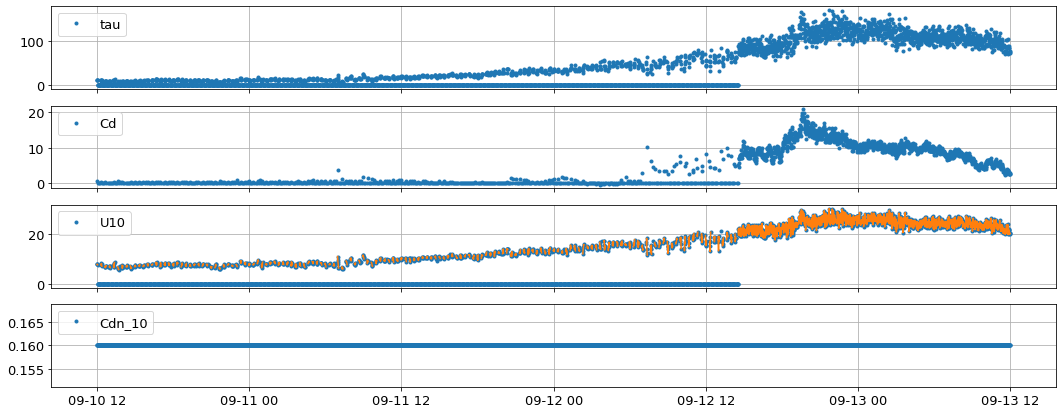

In [ ]:
''' The result: tau/ Cd way too large. The range of U10 looks normal but it should be larger than wdsp input. Cdn_10 is constant...wrong '''
icol = [1,13,32,34]
strs_col = ['tau','Cd','U10','Cdn_10']
nrow = len(strs_col); ncol = 1
plt.clf()
fig = plt.figure(figsize=(18,7))
for i, str_col in enumerate( strs_col ):
    plt.subplot(nrow,ncol,i+1)
    plt.plot(dtime_met_SD[it], C_out[:,icol[i]],'.',label=str_col)
    if i == 2:
        plt.plot(dtime_met_SD[it],wdsp_relative_to_water[it],label='')
    plt.legend(loc='upper left')
    plt.grid()
    if i< nrow-1:
        plt.gca().set_xticklabels([])